In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import mynnlib
from mynnlib import *

dataset_dir = "insect-dataset/cicada"

early_regex = r"^.*-(early)$"
unidentified_regex = r"^.*-(spp|genera|genera-spp)$"
early_or_unidentified_regex = r"^.*-(early|spp|genera|genera-spp)$"

# Create Dataset

In [4]:
if os.path.exists(f"{dataset_dir}/data"):
    shutil.rmtree(f"{dataset_dir}/data")
os.makedirs(f"{dataset_dir}/data")

In [5]:
# merge early and imago classes
src_dir = "insect-dataset/src/indiancicadas.org"
for class_dir in os.listdir(src_dir):
    if not os.path.exists(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}"):
        os.makedirs(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}")
    if os.listdir(f"{src_dir}/{class_dir}"):
        if class_dir.endswith("-early"):
            for file in os.listdir(f"{src_dir}/{class_dir}"):
                shutil.copy2(f"{src_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}/{file}")
        else:
            for file in os.listdir(f"{src_dir}/{class_dir}"):
                shutil.copy2(f"{src_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{class_dir}/{file}")

In [6]:
def copy_data_from(sources, add_early=False):
    class_cnt = 0
    img_cnt = 0
    for more_data_dir in sources:
        for class_dir in os.listdir(f"{dataset_dir}/data"):
            if os.path.exists(f"{more_data_dir}/{class_dir}"):
                # print(f"Copying data for {class_dir}...")
                class_cnt += 1
                for file in os.listdir(f"{more_data_dir}/{class_dir}"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{class_dir}/{file}")
                    img_cnt += 1
            if add_early and os.path.exists(f"{more_data_dir}/{class_dir}-early"):
                # print(f"Copying data for {class_dir}-early...")
                class_cnt += 1
                os.makedirs(f"{dataset_dir}/data/{class_dir}-early/{file}")
                for file in os.listdir(f"{more_data_dir}/{class_dir}-early"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}-early/{file}", f"{dataset_dir}/data/{class_dir}-early/{file}")
                    img_cnt += 1
    print(f"{img_cnt} images added into {class_cnt} classes")

In [7]:
copy_data_from(["insect-dataset/src/inaturalist.org"], add_early=False)

768 images added into 35 classes


In [8]:
removed_cnt = 0
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not os.listdir(f"{dataset_dir}/data/{class_dir}"):
        shutil.rmtree(f"{dataset_dir}/data/{class_dir}")
        removed_cnt += 1
print(f"Removed {removed_cnt} empty classes")

Removed 121 empty classes


In [9]:
remove_file_cnt = 0
valid_file_regex = r"^.*\\.(jpg|jpeg|png|ppm|bmp|pgm|tif|tiff|webp)$"
for class_dir in os.listdir(f"{dataset_dir}/data"):
    for file in os.listdir(f"{dataset_dir}/data/{class_dir}"):
        if not re.match(valid_file_regex, file):
            # os.remove(f"{dataset_dir}/data/{class_dir}/{file}")
            remove_file_cnt += 0
print(f"Removed {remove_file_cnt} unsupported files")

Removed 0 unsupported files


# Create val dataset

In [10]:
if not os.path.exists(f"{dataset_dir}/val"):
    os.makedirs(f"{dataset_dir}/val")

In [11]:
move_src = "data"
move_dst = "val"
val_data_ratio = 0.01
val_data_cnt = 0
for class_dir in os.listdir(f"{dataset_dir}/{move_src}"):
    for file in os.listdir(f"{dataset_dir}/{move_src}/{class_dir}"):
        if random.random() < val_data_ratio:
            if not os.path.exists(f"{dataset_dir}/{move_dst}/{class_dir}"):
                os.makedirs(f"{dataset_dir}/{move_dst}/{class_dir}")
            shutil.move(f"{dataset_dir}/{move_src}/{class_dir}/{file}", f"{dataset_dir}/{move_dst}/{class_dir}/")
            val_data_cnt += 1
print(f"{val_data_cnt} images moved from {move_src} to {move_dst}")

16 images moved from data to val


# Count

In [12]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :    180 ( Unidentified:      0 / Early-stage:      0 / Identified-adult:    180 )
Total  Data count :   1771 ( Unidentified:      0 / Early-stage:      0 / Identified-adult:   1771 )


In [13]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    74 classes with <=2 images
   104 classes with <=5 images


In [14]:
generas = set()
for class_name in classes:
    generas.add(class_name.split('-')[0])
print(f"Genera count: {len(generas)}")

Genera count: 58


# Train

### Model A (resnet-50)

In [15]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet50", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.ta.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.4782 Acc: 0.1412  | Val Loss: 3.8467 Acc: 0.1875  | Elapsed time: 0:00:39.764082
Epoch    2 /    5  | Train Loss: 3.1831 Acc: 0.3162  | Val Loss: 3.0110 Acc: 0.3438  | Elapsed time: 0:01:06.269717
Epoch    3 /    5  | Train Loss: 2.4004 Acc: 0.4675  | Val Loss: 2.3262 Acc: 0.5312  | Elapsed time: 0:01:32.488642
Epoch    4 /    5  | Train Loss: 1.7762 Acc: 0.6245  | Val Loss: 1.8954 Acc: 0.6250  | Elapsed time: 0:01:58.846555
Epoch    5 /    5  | Train Loss: 1.3094 Acc: 0.7420  | Val Loss: 1.5509 Acc: 0.6562  | Elapsed time: 0:02:25.624755
Phase 2:
Epoch    1 /    5  | Train Loss: 2.0995 Acc: 0.5409  | Val Loss: 1.5360 Acc: 0.6875  | Elapsed time: 0:00:25.839088
Epoch    2 /    5  | Train Loss: 1.7627 Acc: 0.6172  | Val Loss: 1.4179 Acc: 0.7188  | Elapsed time: 0:00:52.120409
Epoch    3 /    5  | Train Loss: 1.5564 Acc: 0.6612  | Val Loss: 1.4157 Acc: 0.6875  | Elapsed time: 0:01:18.515850
Phase 3:
Epoch    1 /    5  | Train Loss: 1.6346 Acc: 

### Model B (resnet-101) ***

In [16]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet101", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.tb.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.3823 Acc: 0.1361  | Val Loss: 3.8788 Acc: 0.1562  | Elapsed time: 0:00:36.052703
Epoch    2 /    5  | Train Loss: 3.0609 Acc: 0.3394  | Val Loss: 2.8027 Acc: 0.5000  | Elapsed time: 0:01:12.584967
Epoch    3 /    5  | Train Loss: 2.1181 Acc: 0.5562  | Val Loss: 2.0692 Acc: 0.6250  | Elapsed time: 0:01:48.755397
Epoch    4 /    5  | Train Loss: 1.4211 Acc: 0.7075  | Val Loss: 1.4972 Acc: 0.6875  | Elapsed time: 0:02:25.032676
Epoch    5 /    5  | Train Loss: 0.9489 Acc: 0.8221  | Val Loss: 1.2013 Acc: 0.7188  | Elapsed time: 0:03:01.226855
Phase 2:
Epoch    1 /    5  | Train Loss: 1.8001 Acc: 0.6008  | Val Loss: 1.2676 Acc: 0.7188  | Elapsed time: 0:00:37.473946
Epoch    2 /    5  | Train Loss: 1.4156 Acc: 0.6781  | Val Loss: 1.1628 Acc: 0.7500  | Elapsed time: 0:01:15.402303
Epoch    3 /    5  | Train Loss: 1.1610 Acc: 0.7465  | Val Loss: 1.1163 Acc: 0.7500  | Elapsed time: 0:01:53.749779
Phase 3:
Epoch    1 /    5  | Train Loss: 1.2015 Acc: 

In [20]:
model_data = torch.load(f"{dataset_dir}/checkpoint.cicada.tb.ep060003.pth", weights_only=False)

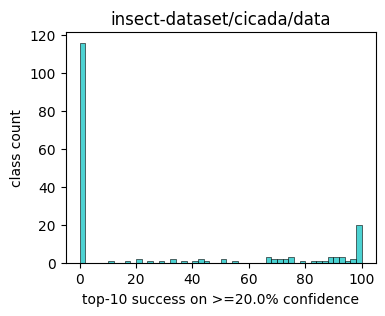

In [21]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.2, k=10)

### Model C (resnet-34)

In [17]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet34", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.tc.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.0401 Acc: 0.2157  | Val Loss: 3.0061 Acc: 0.3750  | Elapsed time: 0:00:22.853247
Epoch    2 /    5  | Train Loss: 2.4528 Acc: 0.5065  | Val Loss: 2.2035 Acc: 0.4688  | Elapsed time: 0:00:46.589591
Epoch    3 /    5  | Train Loss: 1.7044 Acc: 0.6770  | Val Loss: 1.6959 Acc: 0.6562  | Elapsed time: 0:01:09.745984
Epoch    4 /    5  | Train Loss: 1.1965 Acc: 0.7899  | Val Loss: 1.4126 Acc: 0.6562  | Elapsed time: 0:01:32.913761
Phase 2:
Epoch    1 /    5  | Train Loss: 2.3284 Acc: 0.4896  | Val Loss: 1.4854 Acc: 0.6250  | Elapsed time: 0:00:24.587938
Epoch    2 /    5  | Train Loss: 1.9940 Acc: 0.5641  | Val Loss: 1.5214 Acc: 0.6250  | Elapsed time: 0:00:49.241880
Phase 3:
Epoch    1 /    5  | Train Loss: 1.8658 Acc: 0.5985  | Val Loss: 1.3553 Acc: 0.7188  | Elapsed time: 0:00:24.544694
Epoch    2 /    5  | Train Loss: 1.6329 Acc: 0.6635  | Val Loss: 1.3041 Acc: 0.7500  | Elapsed time: 0:00:49.237325
Epoch    3 /    5  | Train Loss: 1.6149 Acc: 